✅ File loaded successfully!
Available categorical columns: ['magencyacro', 'magencyname', 'description', 'projectid', 'budgetline', 'projecttype', 'sagencyacro', 'sagencyname', 'plancommdate', 'projectdescription', 'commitmentdescription', 'commitmentcode', 'typc', 'typcname']
✅ Model Performance:
📌 Mean Absolute Error (MAE): 308.41 days
📌 Root Mean Squared Error (RMSE): 568.82 days
📌 R² Score: 0.9217


<ipython-input-8-7e32a578cae3>:107: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')


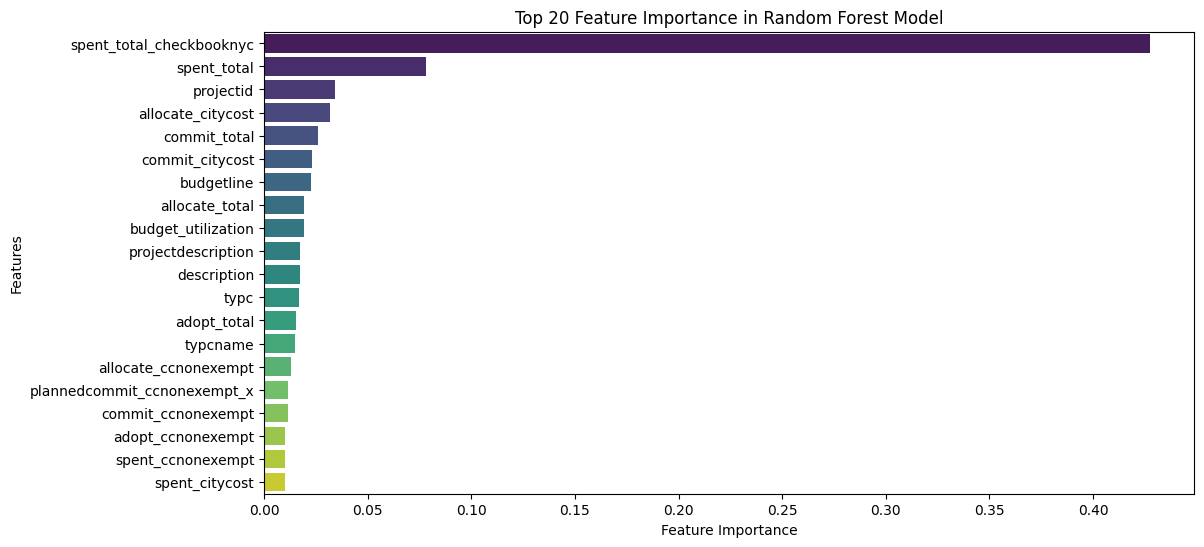

✅ Model saved at: trained_rf_model.pkl


sklearn.ensemble._forest.RandomForestRegressor

In [8]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

file_path = r"cleaned_merged_projects.csv"

if not os.path.exists(file_path):
    print("🚨 ERROR: File not found! Check the path.")
    exit()

df = pd.read_csv(file_path)
print("✅ File loaded successfully!")

drop_cols = ['ccpversion_x', 'maprojid_x', 'ccpversion_y', 'maprojid_y']
df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')


if 'mindate' in df.columns and 'maxdate' in df.columns:
    df['mindate'] = pd.to_datetime(df['mindate'], errors='coerce')
    df['maxdate'] = pd.to_datetime(df['maxdate'], errors='coerce')
    df['project_duration_days'] = (df['maxdate'] - df['mindate']).dt.days  # Target variable
    df.drop(columns=['mindate', 'maxdate'], inplace=True, errors='ignore')

df.fillna(df.median(numeric_only=True), inplace=True)  # Fill numeric columns with median
df.fillna(df.mode().iloc[0], inplace=True)  # Fill categorical columns with mode

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(numeric_only=True), inplace=True)

categorical_cols = [col for col in df.select_dtypes(include=['object']).columns if col in df.columns]

print("Available categorical columns:", categorical_cols)

low_cardinality_cats = [col for col in categorical_cols if df[col].nunique() < 50]
df = pd.get_dummies(df, columns=low_cardinality_cats, drop_first=True)

high_cardinality_cats = [col for col in categorical_cols if col in df.columns and df[col].nunique() >= 50]
label_encoder = LabelEncoder()
for col in high_cardinality_cats:
    df[col] = label_encoder.fit_transform(df[col])
X = df.drop(columns=['project_duration_days'])

X = X.replace([np.inf, -np.inf], np.nan)  # Convert infinity values to NaN
X.fillna(X.median(numeric_only=True), inplace=True)  # Replace NaN with median

selector = VarianceThreshold(threshold=0.01)
X = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

X = X.astype('float32')

y = df['project_duration_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)


print(f"✅ Model Performance:")
print(f"📌 Mean Absolute Error (MAE): {mae:.2f} days")
print(f"📌 Root Mean Squared Error (RMSE): {rmse:.2f} days")
print(f"📌 R² Score: {r2:.4f}")

feature_importances = model.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

top_n = 20
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

plt.figure(figsize=(12, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title(f'Top {top_n} Feature Importance in Random Forest Model')
plt.show()

import joblib


model_path = r"trained_rf_model.pkl"
joblib.dump(model, model_path)

print(f"✅ Model saved at: {model_path}")

type(model)